* Cho dữ liệu Online_Retail.xlsx
* Hãy thực hiện việc phân cụm khách hàng dựa trên các thông tin 'TotalSales', 'OrderCount', 'AvgOrderValue' thu thập và tính toán từ dataset trên.
### Yêu cầu:
* Đọc dữ liệu. Chuẩn hóa dữ liệu. Trích xuất các thuộc tính cần thiết.
* Tìm số cụm phù hợp k?
* Áp dụng thuật toán GMM để giải bài toán phân cụm với số cụm đã tìm được ở câu 2.
* Vẽ hình, xem kết quả. Giải thích từng cụm

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

### 1. Đọc dữ liệu, chuẩn hóa dữ liệu. Trích xuất các thuộc tính cần thiết.

In [2]:
df = pd.read_excel('../../Data/Online_Retail.xlsx', sheet_name='Online Retail',engine='openpyxl')

In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# Loại bỏ các dòng có Quantity ấm (là hàng bị hủy)
df.loc[df['Quantity'] <= 0].shape

(10624, 8)

In [7]:
df = df.loc[df['Quantity'] > 0]

In [8]:
df.shape

(531285, 8)

In [9]:
# Loại bỏ các dòng có CustomerID = NULL
df = df[pd.notnull(df['CustomerID'])]
df.shape

(397924, 8)

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [11]:
# kiểm tra dữ liệu null
print(df.isnull().sum())
# => Không còn dữ liệu null

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [12]:
# Loại bỏ dữ liệu trong tháng chưa hoàn chỉnh là tháng 12/2011
print('Date Range: %s ~ %s' % (df['InvoiceDate'].min(),
                               df['InvoiceDate'].max()))

Date Range: 2010-12-01 08:26:00 ~ 2011-12-09 12:50:00


In [13]:
df.loc[df['InvoiceDate'] >= '2011-12-01'].shape

(17304, 8)

In [14]:
df = df.loc[df['InvoiceDate'] < '2011-12-01']

In [15]:
df.shape

(380620, 8)

In [16]:
# Tính total sales (Sales = Quantity * UnitPrice)
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [17]:
# Tính TotalSales, OrderCount,
# AvgOrderValue cho từng khách hàng CustomerID => customer_df
customer_df = df.groupby('CustomerID').agg({'Sales': sum, 'InvoiceNo': lambda x: x.nunique()})

In [18]:
customer_df.head()

,Sales,InvoiceNo
CustomerID,,
12346.0,77183.60,1
12347.0,4085.18,6
12348.0,1797.24,4
12349.0,1757.55,1
12350.0,334.40,1


In [19]:
# Tạo các cột thuộc tính TotalSales, OrderCount,
# AvgOrderValue cho customer_df
customer_df.columns = ['TotalSales', 'OrderCount']
customer_df['AvgOrderValue']=customer_df['TotalSales']/customer_df['OrderCount']
customer_df.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000


In [20]:
# Thống kê chung
customer_df.describe()

,TotalSales,OrderCount,AvgOrderValue
count,4298.000000,4298.000000,4298.000000
mean,1952.818779,4.131689,400.255621
std,8354.913254,7.420253,1271.187289
min,0.000000,1.000000,0.000000
25%,304.305000,1.000000,178.602500
50%,657.265000,2.000000,295.033958
75%,1599.515000,4.000000,431.594250
max,268478.000000,201.000000,77183.600000


In [21]:
np.ptp(customer_df.TotalSales)

268477.9999999998

In [22]:
np.ptp(customer_df.AvgOrderValue)

77183.6

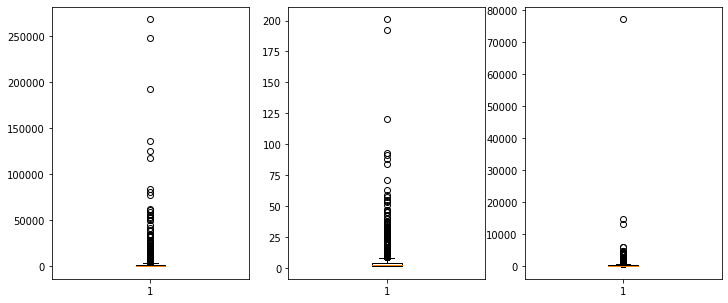

In [23]:
# => Có sự khác biệt về thang đo giữa các cột dữ liệu
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.boxplot(customer_df.TotalSales)
plt.subplot(1,3,2)
plt.boxplot(customer_df.OrderCount)
plt.subplot(1,3,3)
plt.boxplot(customer_df.AvgOrderValue)
plt.show()

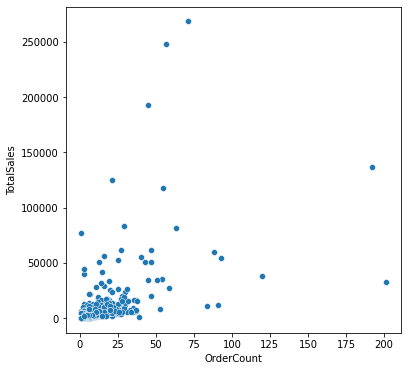

In [24]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=customer_df, y= 'TotalSales', x='OrderCount')
plt.show()

In [25]:
# Theo như quan sát trên ta thấy các mẫu chủ yếu tập trung vào khoảng
# TotalSales ~[0, 15000], và OrderCount ~[1, 20]
customer_sub = customer_df[(customer_df.TotalSales<=15000) & (customer_df.OrderCount <=20)]

In [26]:
customer_sub.shape

(4193, 3)

In [27]:
# số mẫu đã xóa
customer_df.shape[0]-customer_sub.shape[0]

105

In [28]:
# Có outlier trên ở cả 3 features
# Áp dụng RobustScaler để chuẩn hóa
from sklearn.preprocessing import StandardScaler

In [29]:
rs = StandardScaler()
rs.fit(customer_sub)
data = rs.transform(customer_sub)

In [30]:
X = pd.DataFrame(data, columns=['TotalSales', 'OrderCount', 'AvgOrderValue'])

### 2. Tìm số cụm phù hợp k?

In [31]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics

In [32]:
list_sil = [] # Chứa danh sách các giá trị sil
K = range(4,9) # Chứa danh sách số cụm có thể
for k in K:
    gmm = GaussianMixture(n_components=k) # 4,5,6,7,8...
    gmm.fit(X)
    labels = gmm.predict(X)
    # k = 2 => 0 , 1
    # k = 3 => 0, 1, 2
    sil = metrics.silhouette_score(X, labels, metric='euclidean')
    list_sil.append(sil)

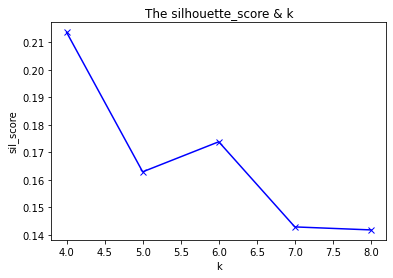

In [33]:
# Plot
plt.plot(K, list_sil, 'bx-')
plt.xlabel('k')
plt.ylabel('sil_score')
plt.title('The silhouette_score & k')
plt.show()

### Số cụm k=4 được đề xuất vì có sil lớn nhất

In [34]:
gmm = GaussianMixture(n_components=4)
gmm.fit(X)

GaussianMixture(n_components=4)

### Sau khi model đã hội tụ, weights, means, và covariances cần phải được giải quyết. In các thông số này:

In [35]:
print(gmm.weights_)

[0.36257488 0.21539258 0.05627408 0.36575847]


In [36]:
print(gmm.means_)

[[-0.54662317 -0.71659373 -0.09316222]
 [ 1.10146914  1.50109284  0.03033644]
 [ 1.26246628 -0.10806573  2.36380645]
 [-0.30101988 -0.15699998 -0.28919901]]


In [37]:
print(gmm.covariances_)

[[[ 2.70167654e-02  2.09146332e-31  1.29415494e-01]
  [ 2.07524791e-31  1.00000000e-06  3.78791929e-32]
  [ 1.29415494e-01  3.37280485e-32  6.19949008e-01]]

 [[ 1.66892160e+00  9.57884072e-01  4.39328152e-01]
  [ 9.57884072e-01  1.28919224e+00 -2.69683748e-02]
  [ 4.39328152e-01 -2.69683748e-02  2.57176030e-01]]

 [[ 2.08355252e+00  4.16933900e-01  1.75586076e+00]
  [ 4.16933900e-01  1.87094820e-01 -1.97526294e-01]
  [ 1.75586076e+00 -1.97526294e-01  5.77812612e+00]]

 [[ 5.73900849e-02  3.76749338e-02  6.64223935e-02]
  [ 3.76749338e-02  8.36413829e-02 -5.50788106e-03]
  [ 6.64223935e-02 -5.50788106e-03  1.26583278e-01]]]


In [38]:
types = gmm.predict(X)

In [39]:
types

array([1, 1, 0, ..., 0, 1, 3], dtype=int64)

In [40]:
X['Group'] = types

In [41]:
customer_sub['Group'] = types

c:\programdata\anaconda3\envs\ai_ocr\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
customer_df.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000


### 3. Vẽ hình, xem kết quả. Giải thích từng cụm.

In [43]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0.92, 'Customer Segmentation')

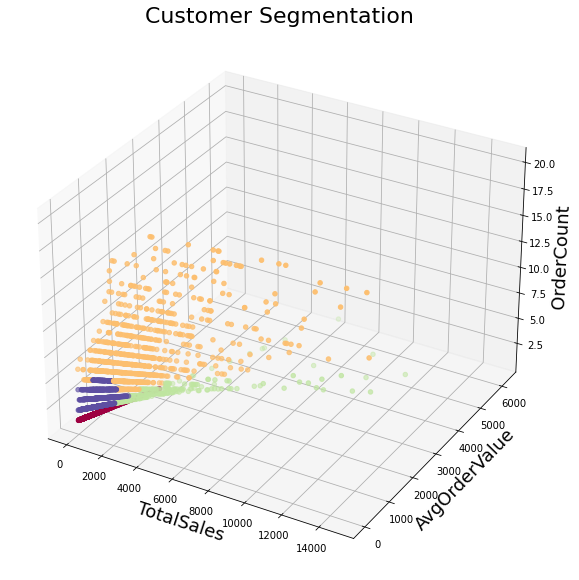

In [44]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(customer_sub.TotalSales, customer_sub.AvgOrderValue,
customer_sub.OrderCount,
c=customer_sub.Group, cmap=plt.cm.Spectral)

ax.set_xlabel("TotalSales", fontsize=18)
ax.set_ylabel("AvgOrderValue", fontsize=18)
ax.set_zlabel("OrderCount", fontsize=18)
ax.set_title("Customer Segmentation", fontsize=22)

In [45]:
X.head()

,TotalSales,OrderCount,AvgOrderValue,Group
0,1.703437,0.791779,0.915087,1
1,0.332692,0.188430,0.250531,1
2,0.308913,-0.716594,4.005172,0
3,-0.543721,-0.716594,-0.079260,0
4,0.757346,1.395127,-0.139946,1


In [46]:
X.groupby('Group').count()

,TotalSales,OrderCount,AvgOrderValue
Group,,,
0,1521,1521,1521
1,898,898,898
2,229,229,229
3,1545,1545,1545


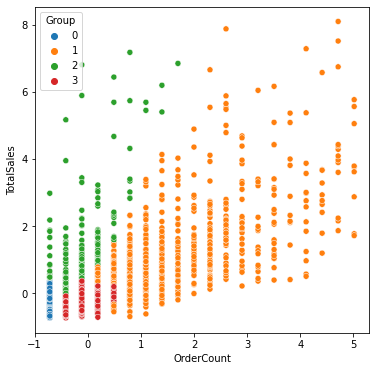

In [47]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=X, x='OrderCount', y='TotalSales', hue='Group', palette='tab10', legend='full', markers='Group')
plt.show()

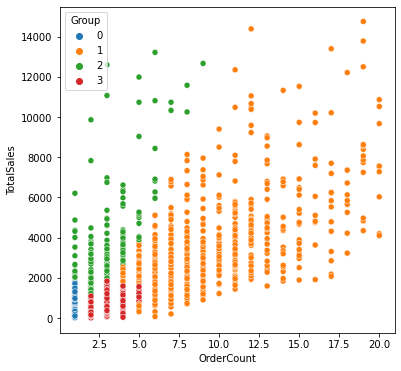

In [48]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=customer_sub, x='OrderCount', y='TotalSales', hue='Group', palette='tab10', legend='full', markers='Group')
plt.show()